# Data Cleaning Project: Air Quality

Tu as reçu un mail de ton manager qui te dit : "Télécharge le jeu de données disponible sur la plateforme Opendatasoft (openaq.csv). Et renvoie-moi d'ici la fin de la journée un fichier csv qui ne comporte aucune erreur, ni information non exploitable. Merci et bon courage."

Disclaimers:  
- Some records contain encoding issues on specific characters; those issues are present in the raw API data and were not corrected.  
- Some dates are set in the future: those issues also come from the original data and were not corrected. 

In [1]:
# Importer les bibliothèques et récupérer le fichier
import pandas as pd
import numpy as np

air_quality = pd.read_csv("openaq.csv", delimiter=";", encoding="utf-8")

# Afficher les premières lignes
air_quality.head()

,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label
0,DE,Manfred Lotz,"Cottbus, W.-Külz-Str.","51.75413,14.325549",PM2.5,EEA Germany,µg/m³,21.7,2016-12-21T12:00:00+01:00,Germany
1,ES,Castellón/Castelló,ES1969A,"39.8236111095,-0.24444444",NO2,EEA Spain,µg/m³,1.0,2021-07-13T08:00:00+02:00,Spain
2,ES,Valencia/València,ES1885A,"39.4802777695,-0.33638888",SO2,EEA Spain,µg/m³,5.0,2021-08-06T11:00:00+02:00,Spain
3,ES,Alicante/Alacant,ES2008A,"37.9911111095,-0.69",PM2.5,EEA Spain,µg/m³,9.0,2021-08-06T11:00:00+02:00,Spain
4,ES,Alicante/Alacant,ES1968A,"38.3511111095,-0.51388888",PM10,EEA Spain,µg/m³,1.0,2021-08-06T11:00:00+02:00,Spain


In [2]:
# Supprimer les données qui ne concernent pas la journée du 06-08-2021.

air_quality = air_quality.loc[air_quality['Last Updated'].str.startswith('2021-08-06')]

air_quality.head()

,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label
2,ES,Valencia/València,ES1885A,"39.4802777695,-0.33638888",SO2,EEA Spain,µg/m³,5.0,2021-08-06T11:00:00+02:00,Spain
3,ES,Alicante/Alacant,ES2008A,"37.9911111095,-0.69",PM2.5,EEA Spain,µg/m³,9.0,2021-08-06T11:00:00+02:00,Spain
4,ES,Alicante/Alacant,ES1968A,"38.3511111095,-0.51388888",PM10,EEA Spain,µg/m³,1.0,2021-08-06T11:00:00+02:00,Spain
5,ES,Valencia/València,ES1911A,"39.7052777695,-0.33666666",CO,EEA Spain,µg/m³,100.0,2021-08-06T11:00:00+02:00,Spain
6,ES,Valencia/València,ES1185A,"39.6672222195,-0.23472222",PM10,EEA Spain,µg/m³,13.0,2021-08-06T11:00:00+02:00,Spain


In [3]:
# Supprimer les données qui sont illisibles et pour lesquelles on ne comprend pas la ville concernée.

print(f"Nombre de lignes avant nettoyage : {len(air_quality)}")

air_quality = air_quality.applymap(lambda x: x.encode('utf-8', 'ignore').decode('utf-8', 'ignore') if isinstance(x, str) else x)
air_quality = air_quality.dropna()

print(f"Nombre de lignes après nettoyage : {len(air_quality)}")

Nombre de lignes avant nettoyage : 24287
Nombre de lignes après nettoyage : 24192


In [4]:
# Pour chaque polluant, vérifier qu'on n'a qu'une seule mesure utilisée. 
# Autrement, supprimer les données qui correspondent à la mesure minoritaire ou moins cohérente.

print(f"Nombre de lignes avant nettoyage : {len(air_quality)}")
# Get the maximum pollutant value recorded for each pollutant and city combination.
PollutantCount = air_quality.groupby(['Pollutant','City'])['Value'].max()

# Inner join of the two dataframes : filters out all rows where the pollutant value is not the 
# maximum value for that pollutant and city combination.
air_quality = pd.merge(air_quality, PollutantCount, on=['Pollutant', 'City', 'Value'], how='inner')

# Delete duplicates based on the combinaison of columns 'Pollutant', 'City' and 'Value', 
# thus eliminating the cases of several maximum values.
air_quality.drop_duplicates(subset=['Pollutant', 'City', 'Value'], inplace=True)

print(f"Nombre de lignes après nettoyage : {len(air_quality)}")

Nombre de lignes avant nettoyage : 24192
Nombre de lignes après nettoyage : 7933


In [5]:
# Enregistrer les données nettoyées dans un nouveau fichier csv

air_quality.to_csv('air_quality_cleaned.csv', index=False)

,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label
1335,ES,Cádiz,ES1593A,"36.4605899995,-6.20307",CO,EEA Spain,µg/m³,1372.0,2021-08-06T08:00:00+02:00,Spain
3417,ES,Málaga,ES2030A,"36.5109999995,-4.863",CO,EEA Spain,µg/m³,1273.0,2021-08-06T08:00:00+02:00,Spain


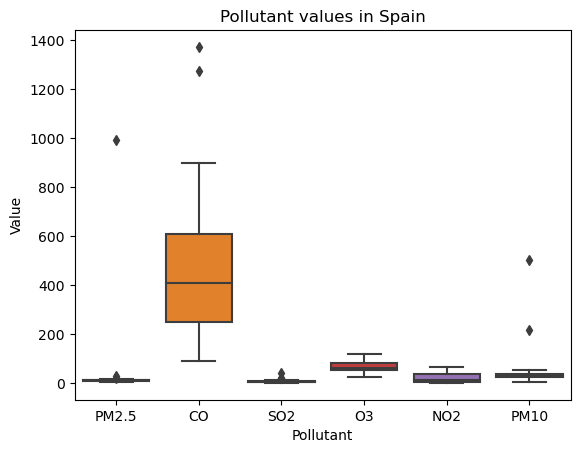

In [6]:
# Regarder s'il y a des valeurs aberrantes ou des problèmes par rapport à notre objectif final 
# (pouvoir comparer des mesures sur un maximum de pays) et noter ces aspects dans un fichier texte.

# ---------------- Method 1: Z-scores
import numpy as np

# Calculate z-scores for CO pollutant values in Spain
spain_CO_zscore = (air_quality[(air_quality['Country Code'] == 'ES') & (air_quality['Pollutant'] == 'CO')]['Value'] - 
                   air_quality[(air_quality['Country Code'] == 'ES') & (air_quality['Pollutant'] == 'CO')]['Value'].mean()) / \
                  air_quality[(air_quality['Country Code'] == 'ES') & (air_quality['Pollutant'] == 'CO')]['Value'].std()

# Define threshold for identifying outliers
threshold = 2

# Create new dataframe with outliers for CO pollutant values in Spain
spain_CO_outliers = air_quality[(air_quality['Country Code'] == 'ES') & (air_quality['Pollutant'] == 'CO')][np.abs(spain_CO_zscore) > threshold]

# Print the new dataframe
display(spain_CO_outliers)
   
# ---------------- Method 2: Box plot
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for Spain
spain_data = air_quality[air_quality['Country Code'] == 'ES']

# Create the box plot using seaborn
sns.boxplot(x='Pollutant', y='Value', data=spain_data)

# Set the title and axis labels
plt.title('Pollutant values in Spain')
plt.xlabel('Pollutant')
plt.ylabel('Value')

# Show the plot
plt.show()